# pre Module 3 - Clip WaPOR data to Area of Interest (AOI)
This Notebook clips the WaPOR data using a shapefile. It contains the following steps
* Step 0 - Import modules/libraries
* Step 1 - Import WaPOR data and AOI
* Step 2 - Clip WaPOR data to boundary (using shapefile)

**=====================================================================================================================**

![title](https://raw.githubusercontent.com/wateraccounting/WaPORIPA/main/images/Clip_image.png)


**=====================================================================================================================**

Before you start running this Notebook, make sure you have the following information:

*   Seasonal outputs from module 1a or 1b (AETI, T, TBP)

*   Shapefile with the Area of Interest (AOI)

## Step 0 - Import modules/libraries

In [21]:
!pip install rasterio --quiet

In [3]:
import os
import glob                           # used to retrieve files/pathnames matching a specified pattern
import rasterio
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import geopandas as gpd
from shapely.geometry import box
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio

##Step 1 - Clip using project boundary

to mount to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

or upload files to temporary folder (data to clip and shapefile for clipping)

In [4]:
#To upload file.
from google.colab import files
uploaded = files.upload()

Saving WaPORv3_seasonal.zip to WaPORv3_seasonal.zip


Unzip the file (either outputs from module 1a (WaPORv3) or module 1b (pyWaPOR))

In [5]:
!unzip '/content/WaPORv3_seasonal.zip' -d '/content'        # unzip WaPORv3 aggregated outputs (module 1a)
#!unzip '/content/pywapor_out.zip' -d '/content'       # unzip pyWaPOR aggregated outputs (module 1b)

Archive:  /content/WaPORv3_seasonal.zip
   creating: /content/content/output/
   creating: /content/content/output/NPP_season/
  inflating: /content/content/output/NPP_season/NPP_season1_2022-10-01_to_2023-04-30.tif  
   creating: /content/content/output/T_season/
  inflating: /content/content/output/T_season/T_season1_2022-10-01_to_2023-04-30.tif  
   creating: /content/content/output/AETI_season/
  inflating: /content/content/output/AETI_season/AETI_season1_2022-10-01_to_2023-04-30.tif  


Define location of the data to clip and output directories

In [6]:
dir_proj = os.path.split(os.getcwd())[0]
dir_data = "/content/content/output/"                           # location of files to be clipped (standard for WaPORv3 seasonal data from module 1a)
#dir_data = "/content/content/output/seasonal/"                 # location of files to be clipped (standard for pyWaPOR seasonal data from module 1b)

input_folderAETI = os.path.join(dir_proj, dir_data, "AETI_season")
input_fhsAETI = glob.glob(os.path.join(input_folderAETI, '*.tif'))

input_folderT = os.path.join(dir_proj, dir_data, "T_season")
input_fhsT = glob.glob(os.path.join(input_folderT, '*.tif'))

input_folderNPP = os.path.join(dir_proj, dir_data, "NPP_season")
input_fhsNPP = glob.glob(os.path.join(input_folderNPP, '*.tif'))

output_folder = '/content/clipped'                    # define folder where results are stored
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

output_folderAETI = os.path.join(dir_proj, output_folder, "AETI_season")
output_folderT = os.path.join(dir_proj, output_folder, "T_season")
output_folderNPP = os.path.join(dir_proj, output_folder, "NPP_season")

if not os.path.exists(output_folderAETI):
    os.makedirs(output_folderAETI)

if not os.path.exists(output_folderT):
    os.makedirs(output_folderT)

if not os.path.exists(output_folderNPP):
    os.makedirs(output_folderNPP)

output_fhsAETI = glob.glob(os.path.join(output_folderAETI, '*.tif'))
output_fhsT = glob.glob(os.path.join(output_folderT, '*.tif'))
output_fhsNPP = glob.glob(os.path.join(output_folderNPP, '*.tif'))


Check raster layer (before clipping to the project area)

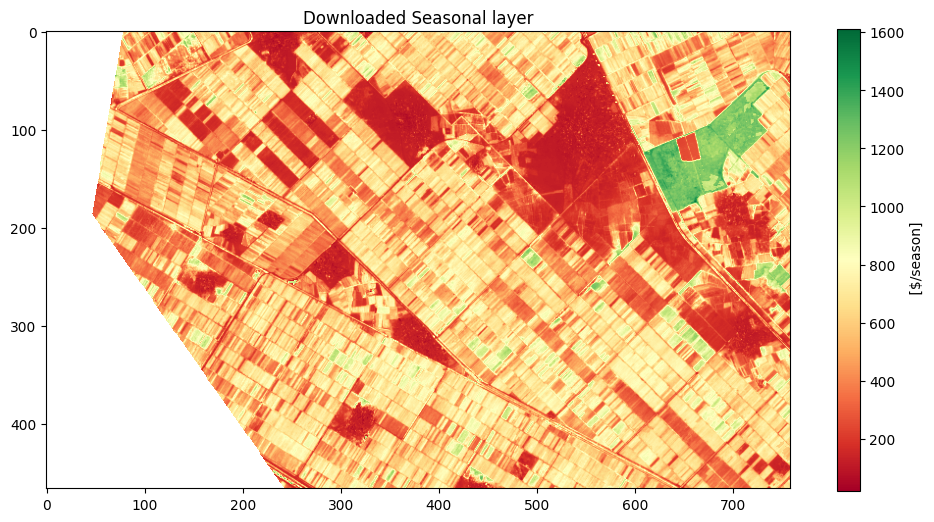

In [7]:
# Open the raster file
Season_tif = rio.open(input_fhsAETI[0])

# Read the first band
Season_data = Season_tif.read(1)

# Plot the data
plt.figure(figsize=(12, 8))
plt.imshow(Season_data, cmap='RdYlGn')
plt.colorbar(shrink=0.75, label=' [$/season]')
plt.title('Downloaded Seasonal layer')
plt.show()

## Define and plot the AOI

Upload the shapefile including all the dependency files

In [13]:
#To upload file.
from google.colab import files
uploaded = files.upload()

Saving Wad_Helal.cpg to Wad_Helal.cpg
Saving Wad_Helal.dbf to Wad_Helal.dbf
Saving Wad_Helal.prj to Wad_Helal.prj
Saving Wad_Helal.qmd to Wad_Helal.qmd
Saving Wad_Helal.shp to Wad_Helal.shp
Saving Wad_Helal.shx to Wad_Helal.shx


In [14]:
shapefile = '/content/Wad_Helal.shp'

''

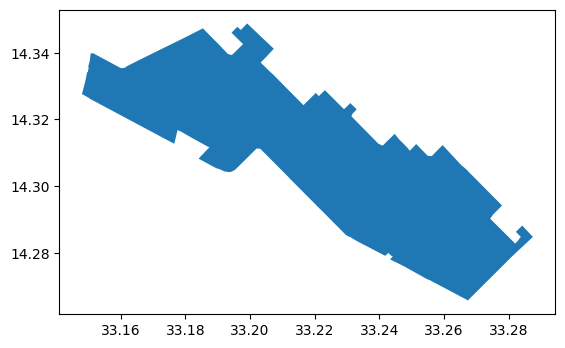

In [15]:
gdf = gpd.read_file(shapefile)
gdf.plot()
gdf
,

##Step 3 - Clip using project boundary

In [16]:
# Function to Clip a raster, and reproject the shapefile if projection is different
def reproject_shapefile(shapefile, dst_crs):
    # Read the shapefile
    gdf = gpd.read_file(shapefile)
    # Reproject to the destination CRS
    gdf = gdf.to_crs(dst_crs)
    return gdf

# Function to clip rasters with a shapefile and handle NaN values
def clip_rasters_with_shapefile(input_folder, shapefile, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Read the shapefile
    gdf = gpd.read_file(shapefile)

    clipped_files = []

    for raster_file in os.listdir(input_folder):
        if raster_file.endswith('.tif'):
            raster_path = os.path.join(input_folder, raster_file)
            with rasterio.open(raster_path) as src:
                # Reproject shapefile if needed
                if gdf.crs != src.crs:
                    gdf = reproject_shapefile(shapefile, src.crs)

                # Get the geometry in the format required by rasterio.mask
                shapes = [feature["geometry"] for feature in gdf.__geo_interface__["features"]]

                # Clip the raster
                out_image, out_transform = mask(src, shapes, crop=True, nodata=np.nan)

                out_meta = src.meta.copy()
                out_meta.update({
                    "driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform,
                    "crs": src.crs,
                    "nodata": np.nan
                })

                # Save the clipped raster
                output_raster_path = os.path.join(output_folder, raster_file)
                with rasterio.open(output_raster_path, "w", **out_meta) as dest:
                    dest.write(out_image)

                clipped_files.append(output_raster_path)

    return clipped_files

In [17]:
# Clip rasters
clipped_files = clip_rasters_with_shapefile(input_folderAETI, shapefile, output_folderAETI)
clipped_files = clip_rasters_with_shapefile(input_folderT, shapefile, output_folderT)
clipped_files = clip_rasters_with_shapefile(input_folderNPP, shapefile, output_folderNPP)


 Check Seasonal raster layer (after clipping to the project area)

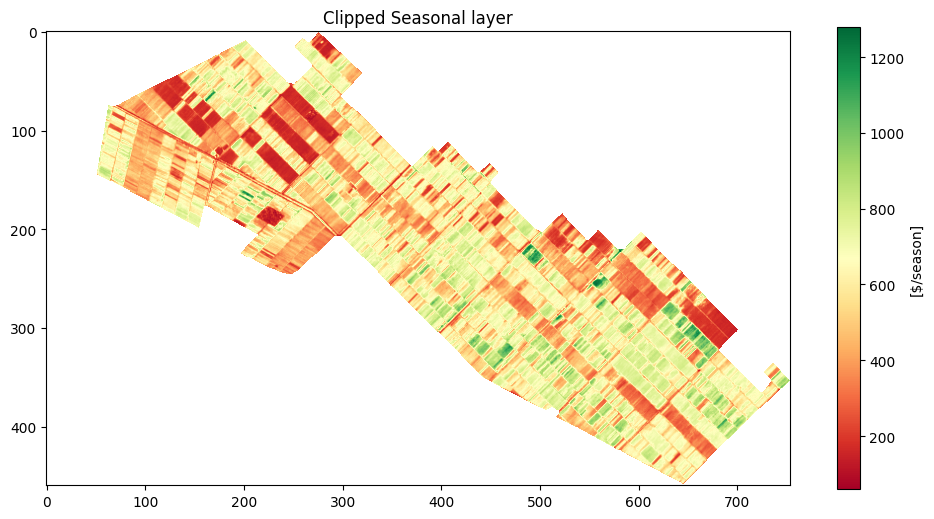

In [18]:
# Open the raster file
output_fhsAETI = glob.glob(os.path.join(output_folderAETI, '*.tif'))
with rio.open(output_fhsAETI[0]) as Clipped:
    # Read the first band of the raster data
    Clipped_data = Clipped.read(1)

# Plot the data
plt.figure(figsize=(12, 8))
plt.imshow(Clipped_data, cmap='RdYlGn')
plt.colorbar(shrink=0.75, label='[$/season]')
plt.title('Clipped Seasonal layer')
plt.show()

download as WaPORv3_clipped.zip

In [19]:
!zip -r /content/WaPORv3_clipped.zip '/content/clipped'
from google.colab import files
files.download(r'/content/WaPORv3_clipped.zip')

  adding: content/clipped/ (stored 0%)
  adding: content/clipped/NPP_season/ (stored 0%)
  adding: content/clipped/NPP_season/NPP_season1_2022-10-01_to_2023-04-30.tif (deflated 82%)
  adding: content/clipped/T_season/ (stored 0%)
  adding: content/clipped/T_season/T_season1_2022-10-01_to_2023-04-30.tif (deflated 87%)
  adding: content/clipped/AETI_season/ (stored 0%)
  adding: content/clipped/AETI_season/AETI_season1_2022-10-01_to_2023-04-30.tif (deflated 87%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download as pyWaPOR_clipped.zip



In [20]:
!zip -r /content/pyWaPOR_clipped.zip '/content/clipped'
from google.colab import files
files.download(r'/content/pyWaPOR_clipped.zip')

  adding: content/clipped/ (stored 0%)
  adding: content/clipped/NPP_season/ (stored 0%)
  adding: content/clipped/NPP_season/NPP_season1_2022-10-01_to_2023-04-30.tif (deflated 82%)
  adding: content/clipped/T_season/ (stored 0%)
  adding: content/clipped/T_season/T_season1_2022-10-01_to_2023-04-30.tif (deflated 87%)
  adding: content/clipped/AETI_season/ (stored 0%)
  adding: content/clipped/AETI_season/AETI_season1_2022-10-01_to_2023-04-30.tif (deflated 87%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>